# Qubit spectroscopy: $T_2^*$ (Ramsey) and $T_2$-echo (Hahn echo)  measurement example

This notebook demonstrates how to assess the dephasing time or [spin–spin relaxation
](https://en.wikipedia.org/wiki/Spin%E2%80%93spin_relaxation), $T_2^*$, and detuning of one or more qubits on a real quantum device using pyQuil. 

A $T_2^*$ Ramsey experiment measures the dephasing time, $T_2^*$, of a qubit and the qubit's detuning, which is a measure of the difference between the qubit's resonant frequency and the frequency of the rotation pulses being used to perform the $T_2^*$ Ramsey experiment. Ideally, this detuning would be 0, meaning our pulses are perfectly tailored to address each qubit without enacting any unintended interactions with neighboring qubits. Practically, however, qubits drift, and the pulse parameters need to be updated. We retune our qubits and pulses regularly, but if you want to assess how well tuned the pulses are to the qubits' frequencies for yourself, you can run a $T_2^*$ Ramsey experiment and see how big the qubit detuning is. 

To design a $T_2^*$ Ramsey experiment, we need to provide a conservative estimate for how big the detuning is. The Ramsey analysis assumes this simulated detuning value, sometimes referred to as TPPI in nuclear magnetic resonance (NMR), is less than the actual qubit detuning, so for a recently retuned chip, it's safe to make an estimate of a few megahertz (MHz). 

A $T_2^*$ Ramsey experiment consists of an X/2 pulse, bringing the qubit to the equator on the Bloch sphere, followed by a delay of variable duration, $t$, during which we expect the qubit to precess about the Z axis on the equator. We then apply a Z rotation through $2\pi * t * \text{detuning}$, where detuning is the simulated detuning. Finally, we apply another X/2 pulse, which, if the precession from the delay and the manual Z rotation offset each other perfectly, should land the qubit in the excited state. When the precession from the delay and the Z rotation do not offset each other perfectly, the qubit does not land perfectly in the excited state, so the excited state visibility oscillates sinusoidally in time, creating fringes. While this is happening, dephasing also causes the state to contract toward the center of the Bloch sphere, away from its surface. This causes the amplitude of the fringes to decay in time, so we expect an exponentially-decaying sinusoidal waveform as a function of the delay time. We calculate the time decay constant from these fringes, as in $T_1$ experiments, and call this quantity $T_2^*$. We also fit to the frequency of the Ramsey fringes to get our calculated detuning. 

A sample QUIL program at one data point (specified by the duration of the DELAY pragma) for qubit 0 with a 10us delay and 5 MHz of simulated detuning (so that $2\pi * t * \text{detuning} = 100\pi$) would look like 

    DECLARE ro BIT[1]
    RX(pi/2) 0
    PRAGMA DELAY 0 "1e-05"
    RZ(100*pi) 0
    RX(pi/2) 0
    MEASURE 0 ro[0]

**NB: Since decoherence and dephasing noise are only simulated on gates, and we make use of DELAY pragmas to simulate relaxation time, we cannot simulate dephasing on the QPU with this experiment as written. This notebook should only be run on a real quantum device.**

setup - imports and relevant units

In [1]:
from matplotlib import pyplot as plt
from pyquil.api import get_qc

from forest.benchmarking.qubit_spectroscopy import (
    generate_t2_star_experiments,
    generate_t2_echo_experiments,
    acquire_qubit_spectroscopy_data,
    fit_t2_results, get_stats_by_qubit)
from forest.benchmarking.plotting import plot_figure_for_fit


We treat SI base units, such as the second, as dimensionless, unit quantities, so we define relative units, such as the microsecond, using scientific notation. 

In [2]:
MHZ = 1e6
MICROSECOND = 1e-6

**Get a quantum computer**

In [3]:
#qc = get_qc('Aspen-1-15Q-A')
qc = get_qc('2q-noisy-qvm') # will run on a QVM, but not meaningfully 
qubits = qc.qubits()
qubits

[0, 1]

## $T_2^*$ Experiment

### Generate simultaneous $T_2^*$ experiments

We can specify which qubits we want to measure using `qubits` and the maximum delay we'll use for each using `stop_time`. 

In [4]:
import numpy as np
stop_time = 13 * MICROSECOND
num_points = 30
times = np.linspace(0, stop_time, num_points)
detune = 5 * MHZ
t2_star_expt = generate_t2_star_experiments(qubits, times, detune)

### Acquire data

Collect our $T_2^*$ raw data using `acquire_t2_data`. 

In [5]:
results = acquire_qubit_spectroscopy_data(qc, t2_star_expt, num_shots=500)

### Analyze and plot

**Use the results to fit a curve and produce estimates of $T_2^*$**

In the cell below we first extract lists of expectations and std_errs from the results and store them separately by qubit. For each qubit we then fit to an exponentially decaying sinusoid and evaluate the fitted `decay_time` constant, i.e. the $T_2^*$, as well as the fitted detuning. Finally we plot the curve fit over the data for each qubit. These are the Ramsey fringes for each qubit with respect to increasing delay duration.

**Note:** in some of the cells below there is a comment `# NBVAL_SKIP` this is used in testing to speed up our tests by skipping that particular cell.

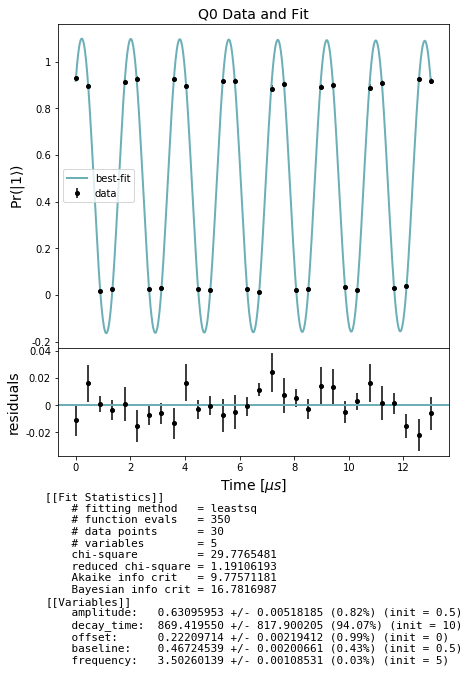

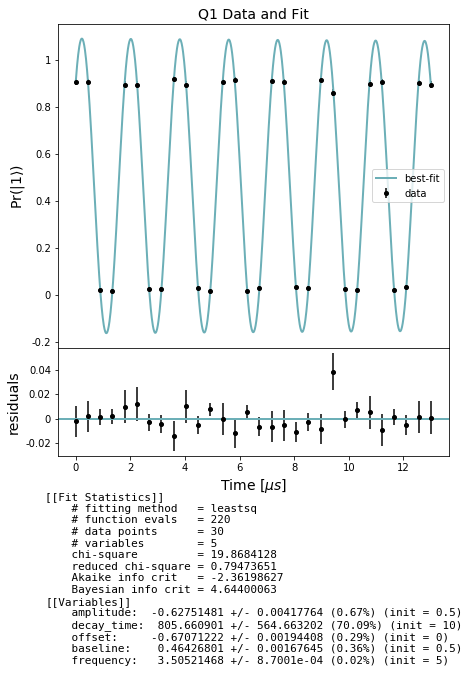

In [6]:
# NBVAL_SKIP

stats_by_qubit = get_stats_by_qubit(results)
for q, stats in stats_by_qubit.items():
    fit = fit_t2_results(np.asarray(times) / MICROSECOND, stats['expectation'],
                         stats['std_err'])
    fig, axs = plot_figure_for_fit(fit, title=f'Q{q} Data and Fit', xlabel=r"Time [$\mu s$]",
                           ylabel=r"Pr($|1\rangle$)")
    t2_star = fit.params['decay_time'].value # in us
    freq = fit.params['frequency'].value # in MHZ

## $T_2$-echo experiment

In [7]:
detune = 5 * MHZ
t2_echo_expt = generate_t2_echo_experiments(qubits, times, detune)

### Acquire data

Collect our $T_2$-echo raw data using `acquire_t2_data`.

In [8]:
echo_results = acquire_qubit_spectroscopy_data(qc, t2_echo_expt)

### Analyze and plot

**Use the results to produce estimates of $T_2$-echo**

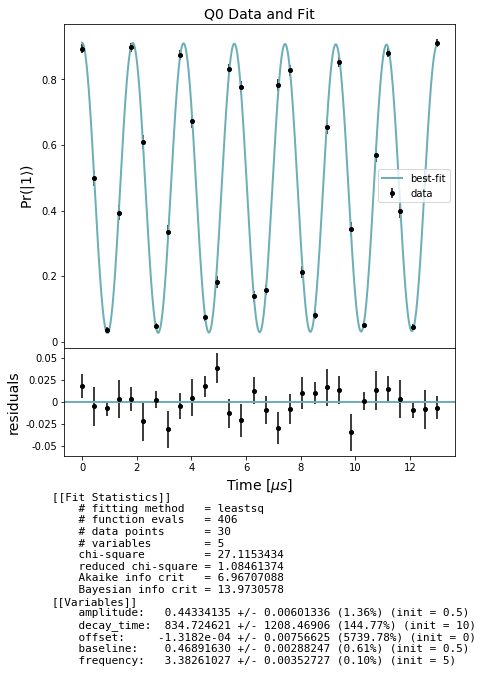

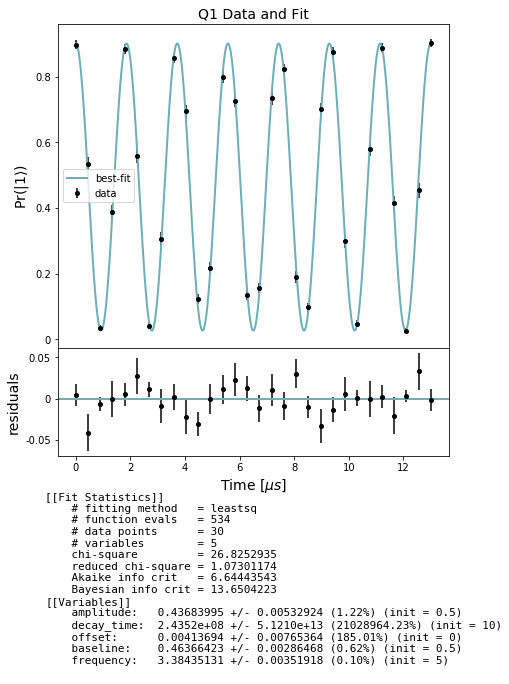

In [9]:
# NBVAL_SKIP

stats_by_qubit = get_stats_by_qubit(echo_results)
for q, stats in stats_by_qubit.items():
    fit = fit_t2_results(np.asarray(times) / MICROSECOND, stats['expectation'],
                         stats['std_err'])
    fig, axs = plot_figure_for_fit(fit, title=f'Q{q} Data and Fit', xlabel=r"Time [$\mu s$]",
                           ylabel=r"Pr($|1\rangle$)")
    t2_echo = fit.params['decay_time'].value # in us
    freq = fit.params['frequency'].value # in MHZ